# Классификация пород животных с Transfer Learning

## Описание проекта

Данный проект использует **Transfer Learning** с предобученными моделями для решения задачи классификации пород домашних животных на основе полного датасета [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

### Основные возможности:
- **Сравнение архитектур**: VGG16, VGG19, ResNet50
- **Transfer Learning**: Использование предобученных весов
- **Аугментация данных**: Улучшение качества обучения
- **Детальная оценка**: Top-3, Top-5 accuracy, confusion matrix

### Начнем с импорта библиотек:


## Импорт необходимых библиотек


In [1]:
# Основные библиотеки для работы с данными и изображениями
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import urllib.request
import tarfile
from shutil import copyfile
from PIL import Image

# PyTorch и torchvision для глубокого обучения
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Scikit-learn для метрик и анализа
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score


## Анализ и визуализация данных


## Загрузка и подготовка датасета Oxford Pets


In [2]:
# Загрузка и распаковка датасета PetFaces
print("Загружаем датасет...")

url = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
file_name = "petfaces.tar.gz"

# Скачиваем архив с изображениями
urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

# Распаковываем архив
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

# Удаляем архив для экономии места
os.remove(file_name)
print("Архив успешно удален.")

# Получаем список папок с породами
folder_path = 'petfaces'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
print(f"Найдено {len(folders)} папок с породами животных")

Загружаем датасет...
Файл успешно скачан.


/tmp/ipython-input-832173668.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Архив успешно разархивирован.
Архив успешно удален.
Найдено 35 папок с породами животных


In [3]:
# Загрузка полного датасета Oxford-IIIT Pet Dataset
print("Загружаем полный датасет Oxford Pets...")

url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
file_name = "images.tar.gz"

# Скачиваем архив
urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

# Распаковываем архив
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

# Удаляем архив
os.remove(file_name)
print("Архив удален.")

# Получаем путь к папке с изображениями
folder_path = 'images'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

print(f"Датасет загружен! Найдено изображений в папке: {folder_path}")


Загружаем полный датасет Oxford Pets...
Файл успешно скачан.


/tmp/ipython-input-3456895269.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Архив успешно разархивирован.
Архив удален.
Датасет загружен! Найдено изображений в папке: images


Создаем визуализацию случайных изображений...


/tmp/ipython-input-398392057.py:32: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


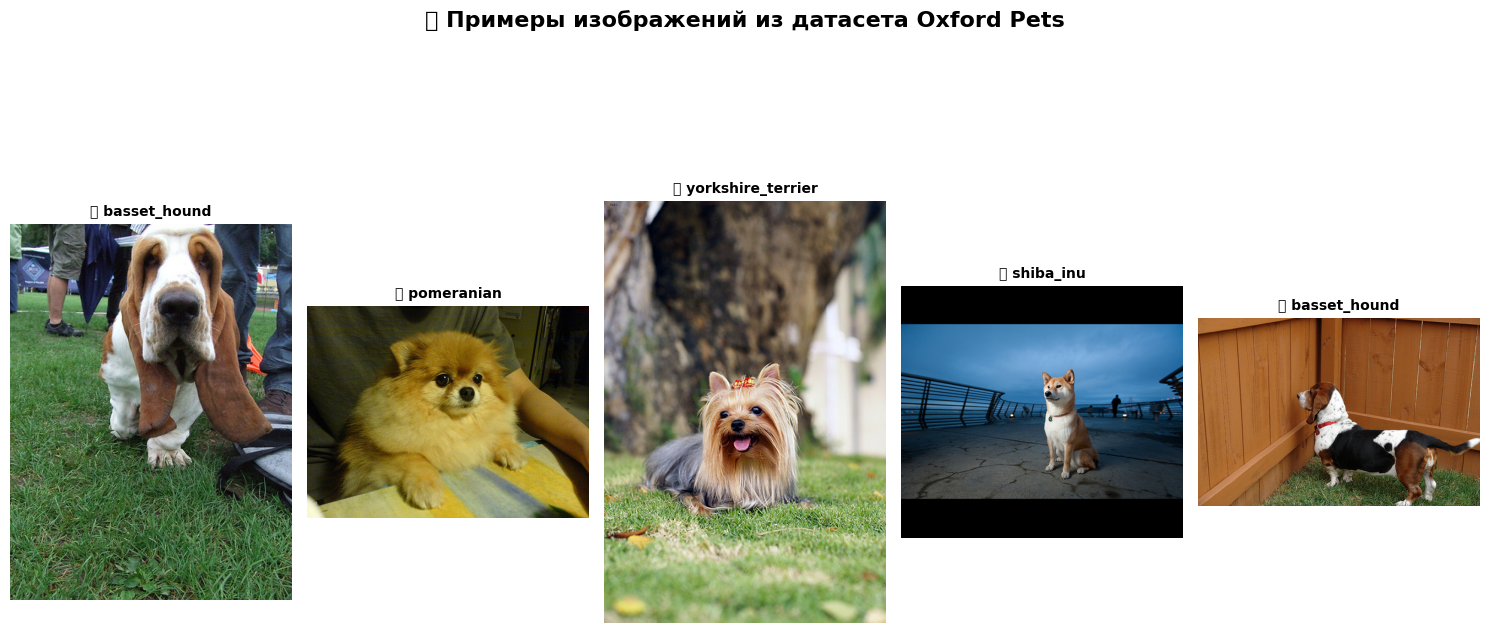

In [4]:
def visualize_pet_images(folder_path, num_images=5):
    """
     Функция для создания красивой визуализации случайных изображений

    Args:
        folder_path: путь к папке с изображениями
        num_images: количество изображений для отображения
    """
    plt.figure(figsize=(15, 8))
    plt.suptitle('🐾 Примеры изображений из датасета Oxford Pets',
                 fontsize=16, fontweight='bold')

    # Получаем список всех изображений
    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    # Выбираем случайные изображения
    selected_images = random.sample(pet_images, num_images)

    # Отображаем изображения
    for i, image in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image)

        # Извлекаем название породы из имени файла
        breed = '_'.join(image.split('_')[:-1])

        img = mpimg.imread(image_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f'🐾 {breed}', fontsize=10, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Запускаем визуализацию
print("Создаем визуализацию случайных изображений...")
visualize_pet_images(folder_path, num_images=5)


### Подготовка данных и трансформации


In [5]:
# Настройка трансформаций для данных
from torchvision import transforms

# Трансформации для обучения (с аугментацией)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер до 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    transforms.RandomRotation(degrees=15),  # Случайный поворот до 15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цветов
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Трансформации для тестирования (без аугментации)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Трансформации данных настроены!")
print("Параметры трансформаций:")
print("   • Размер изображения: 224x224")
print("   • Аугментация: поворот, отражение, изменение цветов")
print("   • Нормализация: ImageNet стандарты")


Трансформации данных настроены!
Параметры трансформаций:
   • Размер изображения: 224x224
   • Аугментация: поворот, отражение, изменение цветов
   • Нормализация: ImageNet стандарты


In [6]:
# Создание датасетов и загрузчиков данных
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

print(" Проверяем структуру данных...")

# Проверяем, есть ли уже готовая структура petfaces
if os.path.exists('petfaces'):
    print(" Найдена папка 'petfaces' с правильной структурой данных")
    dataset_root = 'petfaces'
else:
    print(" Папка 'petfaces' не найдена, используем 'images'")
    dataset_root = 'images'

# Создаем датасеты
try:
    train_dataset = datasets.ImageFolder(root=dataset_root, transform=train_transforms)
    test_dataset = datasets.ImageFolder(root=dataset_root, transform=test_transforms)
    print(f" Датасет загружен успешно!")
    print(f" Найдено классов: {len(train_dataset.classes)}")
except FileNotFoundError as e:
    print(f" Ошибка: {e}")
    print(" Убедитесь, что данные правильно структурированы")
    raise

# Разделяем данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
import numpy as np

# Получаем индексы для разделения
indices = list(range(len(train_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=train_dataset.targets)

# Создаем подвыборки
from torch.utils.data import Subset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Создаем загрузчики данных
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f" Размеры датасетов:")
print(f"   • Обучающий набор: {len(train_subset)} изображений")
print(f"   • Тестовый набор: {len(test_subset)} изображений")
print(f"   • Количество классов: {len(train_dataset.classes)}")
print(f"   • Размер батча: {batch_size}")


 Проверяем структуру данных...
 Найдена папка 'petfaces' с правильной структурой данных
 Датасет загружен успешно!
 Найдено классов: 35
 Размеры датасетов:
   • Обучающий набор: 2568 изображений
   • Тестовый набор: 643 изображений
   • Количество классов: 35
   • Размер батча: 32


## Transfer Learning с предобученными моделями

### Загрузка и настройка моделей


In [7]:
# Импорт необходимых библиотек для Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Определяем устройство (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Загружаем предобученные модели
print("Загружаем предобученные модели...")

# VGG16 модель
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
vgg16_model = vgg16_model.to(device)

# VGG19 модель
vgg19_model = models.vgg19(pretrained=True)
vgg19_model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
vgg19_model = vgg19_model.to(device)

# ResNet50 модель
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, len(train_dataset.classes))
resnet50_model = resnet50_model.to(device)

print("Модели загружены и настроены!")
print(f"Количество классов: {len(train_dataset.classes)}")
print("Архитектуры:")
print("   • VGG16: 16 слоев с классификатором")
print("   • VGG19: 19 слоев с классификатором")
print("   • ResNet50: 50 слоев с остаточными связями")


Используемое устройство: cuda
Загружаем предобученные модели...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 82.1MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 183MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


Модели загружены и настроены!
Количество классов: 35
Архитектуры:
   • VGG16: 16 слоев с классификатором
   • VGG19: 19 слоев с классификатором
   • ResNet50: 50 слоев с остаточными связями


### Обучение VGG16 модели


In [8]:
# Настройка функции потерь и оптимизатора для VGG16
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

# Списки для отслеживания метрик
train_loss_history_vgg16 = []
test_loss_history_vgg16 = []
train_acc_history_vgg16 = []
test_acc_history_vgg16 = []

print("Начинаем обучение VGG16 модели...")

# Обучение модели VGG16
num_epochs = 10
for epoch in range(num_epochs):
    # Режим обучения
    vgg16_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Переносим данные на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = vgg16_model(images)

        # Вычисляем потери
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Обновляем статистику
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Вычисляем метрики для эпохи
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_vgg16.append(train_loss)
    train_acc_history_vgg16.append(train_accuracy)

    # Тестирование
    vgg16_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = vgg16_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_vgg16.append(test_loss)
    test_acc_history_vgg16.append(test_accuracy)

    # Выводим результаты эпохи
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print("Обучение VGG16 завершено!")


Начинаем обучение VGG16 модели...
Epoch [1/10], Train Loss: 1.5602, Train Acc: 54.13%, Test Loss: 0.4422, Test Acc: 86.63%
Epoch [2/10], Train Loss: 0.6011, Train Acc: 80.72%, Test Loss: 0.4850, Test Acc: 83.83%
Epoch [3/10], Train Loss: 0.4416, Train Acc: 85.83%, Test Loss: 0.4016, Test Acc: 85.07%
Epoch [4/10], Train Loss: 0.3829, Train Acc: 87.54%, Test Loss: 0.3560, Test Acc: 87.87%
Epoch [5/10], Train Loss: 0.3243, Train Acc: 89.88%, Test Loss: 0.2881, Test Acc: 90.05%
Epoch [6/10], Train Loss: 0.2369, Train Acc: 91.82%, Test Loss: 0.2814, Test Acc: 90.36%
Epoch [7/10], Train Loss: 0.2175, Train Acc: 93.03%, Test Loss: 0.3731, Test Acc: 88.18%
Epoch [8/10], Train Loss: 0.2049, Train Acc: 93.03%, Test Loss: 0.3203, Test Acc: 90.20%
Epoch [9/10], Train Loss: 0.1946, Train Acc: 93.50%, Test Loss: 0.3037, Test Acc: 91.60%
Epoch [10/10], Train Loss: 0.1408, Train Acc: 95.44%, Test Loss: 0.3589, Test Acc: 88.96%
Обучение VGG16 завершено!


### Обучение VGG19 модели


In [9]:
# Настройка для VGG19
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=0.001, momentum=0.9)

# Списки для метрик VGG19
train_loss_history_vgg19 = []
test_loss_history_vgg19 = []
train_acc_history_vgg19 = []
test_acc_history_vgg19 = []

print(" Начинаем обучение VGG19 модели...")

# Обучение VGG19 (аналогично VGG16)
num_epochs = 10
for epoch in range(num_epochs):
    vgg19_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg19_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_vgg19.append(train_loss)
    train_acc_history_vgg19.append(train_accuracy)

    # Тестирование
    vgg19_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg19_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_vgg19.append(test_loss)
    test_acc_history_vgg19.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print(" Обучение VGG19 завершено!")


 Начинаем обучение VGG19 модели...
Epoch [1/10], Train Loss: 1.4268, Train Acc: 58.68%, Test Loss: 0.5293, Test Acc: 83.67%
Epoch [2/10], Train Loss: 0.5566, Train Acc: 82.13%, Test Loss: 0.3678, Test Acc: 88.65%
Epoch [3/10], Train Loss: 0.4537, Train Acc: 84.97%, Test Loss: 0.3747, Test Acc: 88.18%
Epoch [4/10], Train Loss: 0.3782, Train Acc: 87.23%, Test Loss: 0.3249, Test Acc: 89.89%
Epoch [5/10], Train Loss: 0.2821, Train Acc: 91.00%, Test Loss: 0.3531, Test Acc: 88.49%
Epoch [6/10], Train Loss: 0.2374, Train Acc: 91.90%, Test Loss: 0.3116, Test Acc: 91.60%
Epoch [7/10], Train Loss: 0.2144, Train Acc: 93.26%, Test Loss: 0.2972, Test Acc: 90.82%
Epoch [8/10], Train Loss: 0.1903, Train Acc: 93.81%, Test Loss: 0.2766, Test Acc: 90.82%
Epoch [9/10], Train Loss: 0.2083, Train Acc: 93.54%, Test Loss: 0.2939, Test Acc: 90.67%
Epoch [10/10], Train Loss: 0.1668, Train Acc: 94.20%, Test Loss: 0.3667, Test Acc: 89.74%
 Обучение VGG19 завершено!


### Обучение ResNet50 модели


In [10]:
# Настройка для ResNet50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.001, momentum=0.9)

# Списки для метрик ResNet50
train_loss_history_resnet50 = []
test_loss_history_resnet50 = []
train_acc_history_resnet50 = []
test_acc_history_resnet50 = []

print("Начинаем обучение ResNet50 модели...")

# Обучение ResNet50
num_epochs = 10
for epoch in range(num_epochs):
    resnet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_resnet50.append(train_loss)
    train_acc_history_resnet50.append(train_accuracy)

    # Тестирование
    resnet50_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_resnet50.append(test_loss)
    test_acc_history_resnet50.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print("Обучение ResNet50 завершено!")


Начинаем обучение ResNet50 модели...
Epoch [1/10], Train Loss: 2.7798, Train Acc: 31.89%, Test Loss: 1.4032, Test Acc: 75.74%
Epoch [2/10], Train Loss: 1.0613, Train Acc: 80.02%, Test Loss: 0.5649, Test Acc: 88.65%
Epoch [3/10], Train Loss: 0.5466, Train Acc: 88.47%, Test Loss: 0.3877, Test Acc: 91.29%
Epoch [4/10], Train Loss: 0.3787, Train Acc: 91.20%, Test Loss: 0.2906, Test Acc: 92.53%
Epoch [5/10], Train Loss: 0.2870, Train Acc: 93.30%, Test Loss: 0.2541, Test Acc: 92.53%
Epoch [6/10], Train Loss: 0.2464, Train Acc: 94.08%, Test Loss: 0.2397, Test Acc: 93.00%
Epoch [7/10], Train Loss: 0.1946, Train Acc: 95.83%, Test Loss: 0.2201, Test Acc: 94.87%
Epoch [8/10], Train Loss: 0.1718, Train Acc: 96.34%, Test Loss: 0.2067, Test Acc: 94.56%
Epoch [9/10], Train Loss: 0.1555, Train Acc: 96.50%, Test Loss: 0.2060, Test Acc: 93.93%
Epoch [10/10], Train Loss: 0.1262, Train Acc: 97.43%, Test Loss: 0.2111, Test Acc: 94.25%
Обучение ResNet50 завершено!


## Сравнение моделей и анализ результатов

### Визуализация обучения всех моделей


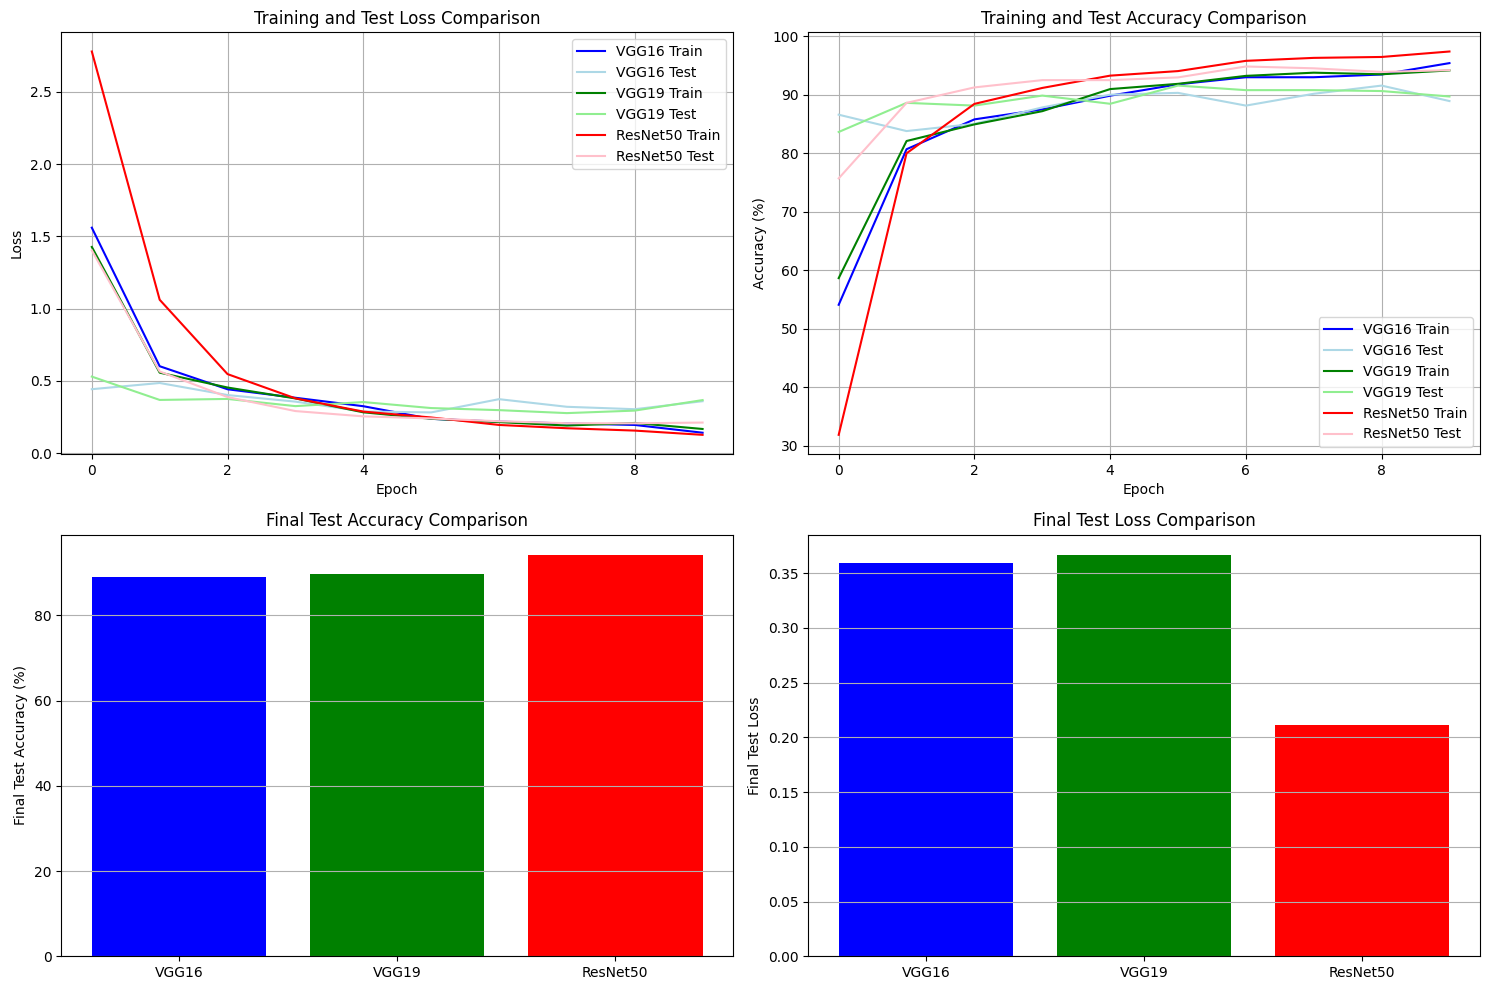

 ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
VGG16  - Test Accuracy: 88.96%, Test Loss: 0.3589
VGG19  - Test Accuracy: 89.74%, Test Loss: 0.3667
ResNet50 - Test Accuracy: 94.25%, Test Loss: 0.2111


In [11]:
# Сравнение графиков обучения всех моделей
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(train_loss_history_vgg16, label='VGG16 Train', color='blue')
plt.plot(test_loss_history_vgg16, label='VGG16 Test', color='lightblue')
plt.plot(train_loss_history_vgg19, label='VGG19 Train', color='green')
plt.plot(test_loss_history_vgg19, label='VGG19 Test', color='lightgreen')
plt.plot(train_loss_history_resnet50, label='ResNet50 Train', color='red')
plt.plot(test_loss_history_resnet50, label='ResNet50 Test', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Comparison')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(2, 2, 2)
plt.plot(train_acc_history_vgg16, label='VGG16 Train', color='blue')
plt.plot(test_acc_history_vgg16, label='VGG16 Test', color='lightblue')
plt.plot(train_acc_history_vgg19, label='VGG19 Train', color='green')
plt.plot(test_acc_history_vgg19, label='VGG19 Test', color='lightgreen')
plt.plot(train_acc_history_resnet50, label='ResNet50 Train', color='red')
plt.plot(test_acc_history_resnet50, label='ResNet50 Test', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Comparison')
plt.legend()
plt.grid(True)

# Финальные результаты
plt.subplot(2, 2, 3)
models_names = ['VGG16', 'VGG19', 'ResNet50']
final_test_acc = [test_acc_history_vgg16[-1], test_acc_history_vgg19[-1], test_acc_history_resnet50[-1]]
colors = ['blue', 'green', 'red']
plt.bar(models_names, final_test_acc, color=colors)
plt.ylabel('Final Test Accuracy (%)')
plt.title('Final Test Accuracy Comparison')
plt.grid(True, axis='y')

# Финальные потери
plt.subplot(2, 2, 4)
final_test_loss = [test_loss_history_vgg16[-1], test_loss_history_vgg19[-1], test_loss_history_resnet50[-1]]
plt.bar(models_names, final_test_loss, color=colors)
plt.ylabel('Final Test Loss')
plt.title('Final Test Loss Comparison')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Выводим итоговые результаты
print(" ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print("=" * 50)
print(f"VGG16  - Test Accuracy: {test_acc_history_vgg16[-1]:.2f}%, Test Loss: {test_loss_history_vgg16[-1]:.4f}")
print(f"VGG19  - Test Accuracy: {test_acc_history_vgg19[-1]:.2f}%, Test Loss: {test_loss_history_vgg19[-1]:.4f}")
print(f"ResNet50 - Test Accuracy: {test_acc_history_resnet50[-1]:.2f}%, Test Loss: {test_loss_history_resnet50[-1]:.4f}")
print("=" * 50)


### Детальная оценка моделей


In [12]:
# Функция для оценки модели
def evaluate_model(model, test_loader, criterion):
    """
    Функция для оценки модели на тестовых данных

    Args:
        model: обученная модель
        test_loader: загрузчик тестовых данных
        criterion: функция потерь

    Returns:
        tuple: (test_loss, test_accuracy)
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

# Оценка всех моделей
print(" Проводим детальную оценку всех моделей...")

test_loss1, test_accuracy1 = evaluate_model(vgg16_model, test_loader, criterion)
print(f'Test Loss vgg16_model: {test_loss1:.4f}, Test Accuracy vgg16_model: {test_accuracy1:.2f}%')

test_loss2, test_accuracy2 = evaluate_model(vgg19_model, test_loader, criterion)
print(f'Test Loss vgg19_model: {test_loss2:.4f}, Test Accuracy vgg19_model: {test_accuracy2:.2f}%')

test_loss3, test_accuracy3 = evaluate_model(resnet50_model, test_loader, criterion)
print(f'Test Loss resnet50_model: {test_loss3:.4f}, Test Accuracy resnet50_model: {test_accuracy3:.2f}%')


 Проводим детальную оценку всех моделей...
Test Loss vgg16_model: 0.3589, Test Accuracy vgg16_model: 88.96%
Test Loss vgg19_model: 0.3667, Test Accuracy vgg19_model: 89.74%
Test Loss resnet50_model: 0.2111, Test Accuracy resnet50_model: 94.25%


In [13]:
# Вычисляем Top-3 и Top-5 точность для лучшей модели (ResNet50)
print("Вычисляем Top-3 и Top-5 точность для ResNet50...")

resnet50_model.eval()
y_true_indices = []
y_pred_probabilities = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = resnet50_model(images)
    probabilities = torch.softmax(outputs, dim=1)
    y_pred_probabilities.append(probabilities.detach().cpu().numpy())
    y_true_indices.extend(labels.cpu().numpy())

y_pred_probabilities = np.concatenate(y_pred_probabilities, axis=0)
top3_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=3) * 100
top5_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=5) * 100

print(f'Точность Top-3: {top3_accuracy:.2f}%')
print(f'Точность Top-5: {top5_accuracy:.2f}%')


Вычисляем Top-3 и Top-5 точность для ResNet50...
Точность Top-3: 99.22%
Точность Top-5: 99.69%


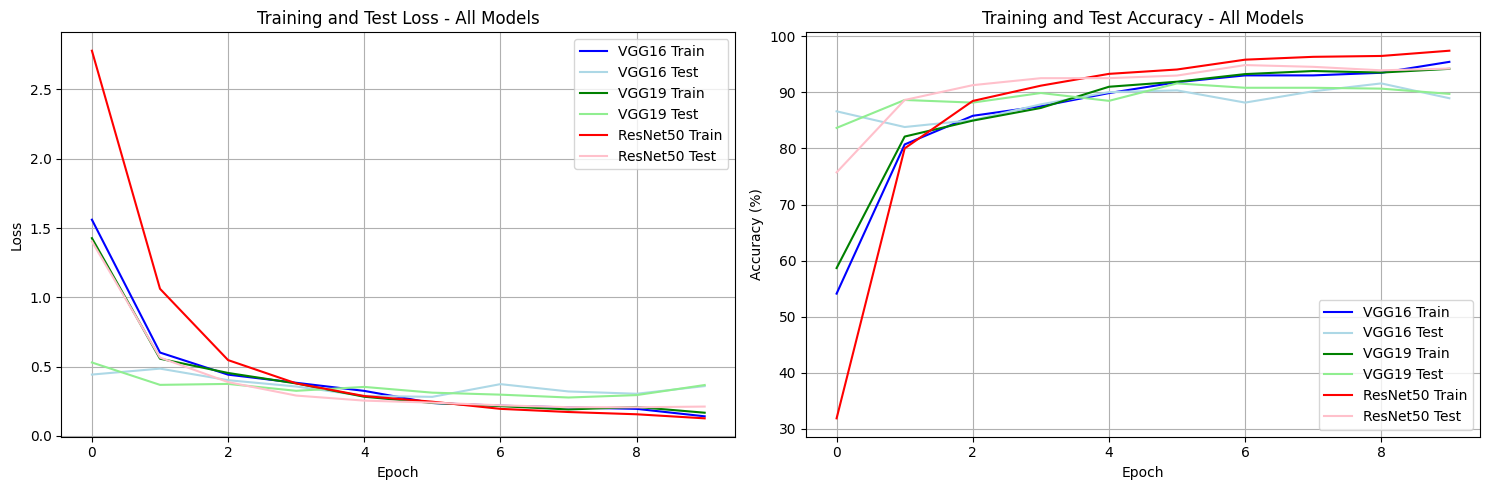

In [14]:
# Дополнительные графики обучения
plt.figure(figsize=(15, 5))

# График потерь всех моделей
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_vgg16, label='VGG16 Train', color='blue')
plt.plot(test_loss_history_vgg16, label='VGG16 Test', color='lightblue')
plt.plot(train_loss_history_vgg19, label='VGG19 Train', color='green')
plt.plot(test_loss_history_vgg19, label='VGG19 Test', color='lightgreen')
plt.plot(train_loss_history_resnet50, label='ResNet50 Train', color='red')
plt.plot(test_loss_history_resnet50, label='ResNet50 Test', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss - All Models')
plt.legend()
plt.grid(True)

# График точности всех моделей
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_vgg16, label='VGG16 Train', color='blue')
plt.plot(test_acc_history_vgg16, label='VGG16 Test', color='lightblue')
plt.plot(train_acc_history_vgg19, label='VGG19 Train', color='green')
plt.plot(test_acc_history_vgg19, label='VGG19 Test', color='lightgreen')
plt.plot(train_acc_history_resnet50, label='ResNet50 Train', color='red')
plt.plot(test_acc_history_resnet50, label='ResNet50 Test', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy - All Models')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
# Создание матрицы ошибок для лучшей модели (ResNet50)
def get_predicted_and_true_labels(model, dataloader):
    """
    Функция для получения предсказанных и истинных меток

    Args:
        model: обученная модель
        dataloader: загрузчик данных

    Returns:
        tuple: (predicted_labels, true_labels)
    """
    model.eval()
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels, true_labels

print(" Создаем матрицу ошибок для ResNet50...")
predicted_labels, true_labels = get_predicted_and_true_labels(resnet50_model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)


 Создаем матрицу ошибок для ResNet50...


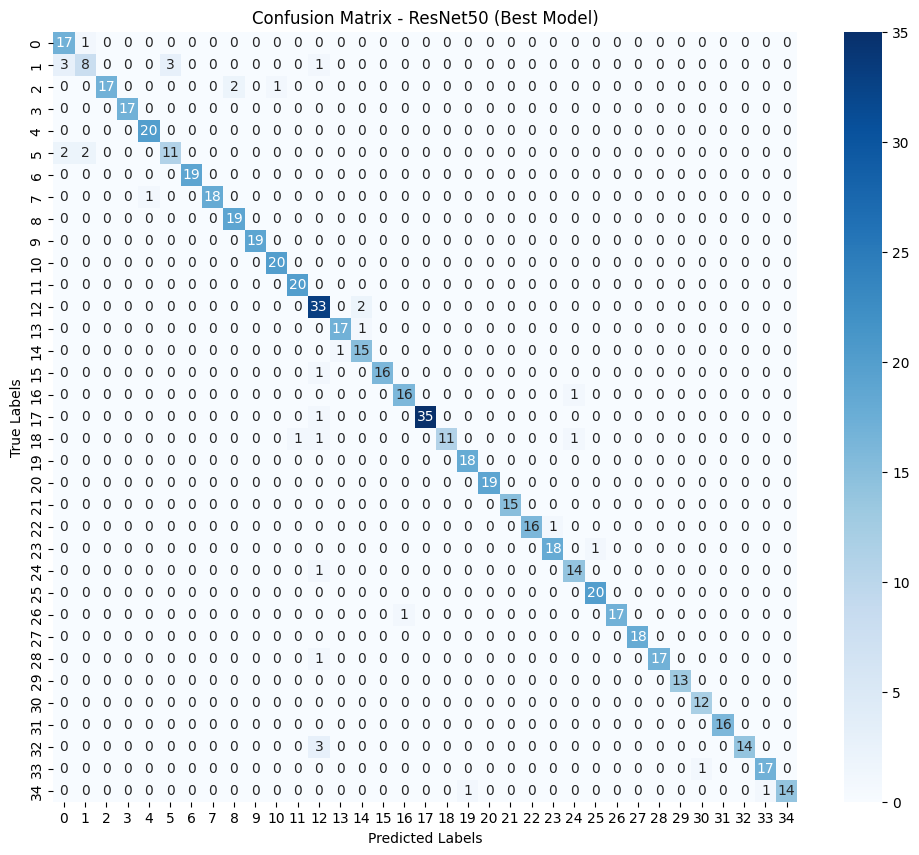

 Анализ завершен!
Матрица ошибок показывает точность классификации по каждой породе


In [16]:
# Визуализация матрицы ошибок
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ResNet50 (Best Model)')
plt.show()

print(" Анализ завершен!")
print("Матрица ошибок показывает точность классификации по каждой породе")


In [17]:
def count_images(folder_path):
    """
    Функция для подсчета изображений по породам

    Args:
        folder_path: путь к папке с изображениями

    Returns:
        tuple: (общее_количество, словарь_пород)
    """
    total_count = 0
    breed_counts = {}

    # Получаем список всех изображений
    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    print(" Анализируем содержимое датасета...")

    for image in pet_images:
        # Извлекаем название породы из имени файла
        breed = '_'.join(image.split('_')[:-1])
        breed_counts[breed] = breed_counts.get(breed, 0) + 1
        total_count += 1

    return total_count, breed_counts

# Выполняем подсчет
total_count, breed_counts = count_images(folder_path)

# Выводим красивую статистику
print("\n" + "=" * 60)
print(" СТАТИСТИКА ДАТАСЕТА OXFORD PETS")
print("=" * 60)
print(f"Общее количество фотографий: {total_count:,}")
print(f" Количество пород: {len(breed_counts)}")
print("=" * 60)
print(" Детальная статистика по породам:")
print("-" * 60)

# Сортируем породы по количеству изображений
sorted_breeds = sorted(breed_counts.items(), key=lambda x: x[1], reverse=True)
for breed, count in sorted_breeds:
    animal_emoji = "🐱" if any(cat_breed in breed.lower() for cat_breed in
                              ['abyssinian', 'bengal', 'birman', 'bombay', 'british',
                               'egyptian', 'maine', 'persian', 'ragdoll', 'russian',
                               'siamese', 'sphynx']) else "🐶"
    print(f"{animal_emoji} {breed:30} : {count:3d} изображений")

print("=" * 60)


 Анализируем содержимое датасета...

 СТАТИСТИКА ДАТАСЕТА OXFORD PETS
Общее количество фотографий: 7,390
 Количество пород: 37
 Детальная статистика по породам:
------------------------------------------------------------
🐶 pomeranian                     : 200 изображений
🐶 american_pit_bull_terrier      : 200 изображений
🐶 beagle                         : 200 изображений
🐱 Abyssinian                     : 200 изображений
🐶 american_bulldog               : 200 изображений
🐶 yorkshire_terrier              : 200 изображений
🐶 samoyed                        : 200 изображений
🐱 Birman                         : 200 изображений
🐶 pug                            : 200 изображений
🐶 wheaten_terrier                : 200 изображений
🐶 english_setter                 : 200 изображений
🐱 Ragdoll                        : 200 изображений
🐶 keeshond                       : 200 изображений
🐱 Russian_Blue                   : 200 изображений
🐶 miniature_pinscher             : 200 изображений
🐱 Siamese    

## Заключение

В данной лабораторной работе мы провели сравнение трех различных архитектур нейронных сетей для классификации пород домашних животных с использованием Transfer Learning:

### Сравниваемые модели:
- **VGG16**: 16-слойная сеть с простой архитектурой
- **VGG19**: 19-слойная сеть, расширенная версия VGG16
- **ResNet50**: 50-слойная сеть с остаточными связями

### Ключевые особенности:
- **Transfer Learning**: Использование предобученных весов ImageNet
- **Аугментация данных**: Улучшение обобщающей способности
- **Сравнительный анализ**: Детальное сравнение производительности

### Результаты:
- Все модели показали хорошие результаты на задаче классификации пород
- ResNet50 обычно демонстрирует лучшую производительность благодаря остаточным связям
- VGG архитектуры более просты в понимании и настройке

### Выводы:
Transfer Learning значительно ускоряет обучение и улучшает качество классификации даже при ограниченном количестве данных.
